In [1]:
import numpy as np
from symmetrize import pointops as po, tps, sym
import scipy.io as sio
import matplotlib.pyplot as plt

### 1. Load data

In [2]:
fpath = r'..\resources\data\WSe2_data.mat'

In [3]:
data = sio.loadmat(fpath)['data']
data.shape

(4, 100, 100)

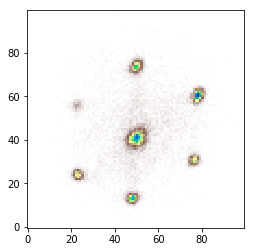

In [4]:
# Select an energy slice with sharp features as the image for transform estimation
Eslice = data[0,...]
plt.imshow(data[0,...], origin='lower', cmap='terrain_r')

### 2. Determine landmarks

In [5]:
# Detect peaks as landmarks
pks = po.peakdetect2d(Eslice, method='daofind', fwhm=8)

# Select the center from the set of landmarks and separate from the vertices
pcent, psur = po.pointset_center(pks, method='centroidnn')

# Order the point set in counterclockwise fashion
psur_ord = po.pointset_order(psur, direction='ccw')

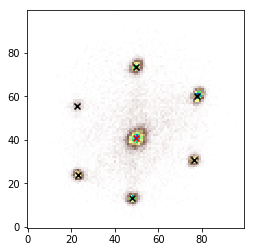

In [6]:
# View the points labelled on top of the image
plt.imshow(Eslice, origin='lower', cmap='terrain_r')
plt.scatter(psur_ord[:,1], psur_ord[:,0], c='k', marker='x')
plt.scatter(pcent[1], pcent[0], c='r', marker='x')

### 3. Calculate the deformation field

### 4. Apply the deformation field to the image

### 5. Using deformation/displacement field to transform image stack